CSV loaded successfully without header.
Data Head:
        x1        x2  label
0  0.78051 -0.063669      1
1  0.28774  0.291390      1
2  0.40714  0.178780      1
3  0.29230  0.421700      1
4  0.50922  0.352560      1

Plotting Initial Data...


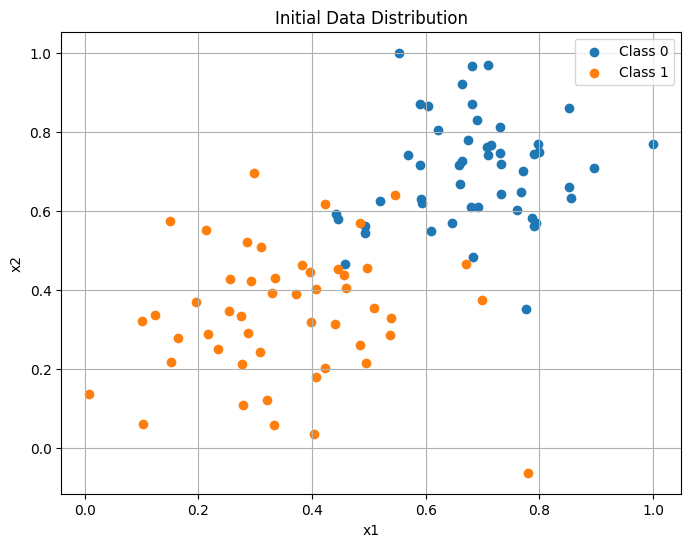

In [2]:
# Cell 1: Imports, Load Data, and Plot Initial Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
DATA_FILE = 'data.csv' 

# --- Load Data ---
try:
    df = pd.read_csv(DATA_FILE, header=None)
    # Rename columns for clarity
    df.columns = ['x1', 'x2', 'label']
    print("CSV loaded successfully without header.")
except Exception as e:
    print(f"Error loading CSV: {e}")
    print("Please ensure 'data.csv' exists and is readable.")
    # Create dummy data if file loading fails, to allow code execution
    print("Creating dummy data...")
    X_dummy = np.random.rand(100, 2)
    y_dummy = (X_dummy[:, 0] + X_dummy[:, 1] > 1).astype(int)
    df = pd.DataFrame({'x1': X_dummy[:, 0], 'x2': X_dummy[:, 1], 'label': y_dummy})


# Verify data and extract X, y
print("Data Head:")
print(df.head())
X = df[['x1', 'x2']].values
y = df['label'].values

# Ensure labels are 0 and 1 (important for perceptron logic)
unique_labels = np.unique(y)
if not np.all(np.isin(unique_labels, [0, 1])):
    print(f"Warning: Labels are {unique_labels}. Adjusting to 0 and 1...")
    # Adjust labels based on the first unique value being 0, second being 1
    y = (y == unique_labels[1]).astype(int)
    print(f"Labels adjusted to {np.unique(y)}")


# --- Plot Initial Data ---
print("\nPlotting Initial Data...")
plt.figure(figsize=(8, 6))
for label_val in np.unique(y):
    plt.scatter(X[y == label_val][:, 0], X[y == label_val][:, 1],
                label=f'Class {label_val}')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Initial Data Distribution')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
# Heuristic Perceptron Function Definition 

def sign(x):
    """Sign activation function (returns 0 or 1)."""
    return 1 if x >= 0 else 0
    
def perceptron_heuristic(X_orig, y_orig, learning_rate=0.1, max_iter=100, plot_interval=10):
    """
    Implements the Perceptron algorithm using the heuristic approach.
    Plots decision boundary every plot_interval iterations.
    """
    # Adding bias term (column of ones) to X
    X_bias = np.hstack((np.ones((X_orig.shape[0], 1)), X_orig))
    n_samples, n_features_with_bias = X_bias.shape

    # Initialize weights
    w = np.random.randn(n_features_with_bias) * 0.01
    lines_history = [w.copy()] # Store initial weights

    print(f"Starting Heuristic Perceptron (LR={learning_rate}, MaxIter={max_iter})")
    
    # Plot initial boundary
    plot_decision_lines(X_orig, y_orig, lines_history,
                        title=f"Heuristic Boundary - Initial State",
                        is_intermediate_plot=True) # Pass flag

    for iteration in range(max_iter):
        error_count = 0
        updates_in_iter = 0
        
        # Iterate through each sample
        for xi, target in zip(X_bias, y_orig):
            prediction = sign(np.dot(xi, w))
            if prediction != target:
                error_count += 1
                updates_in_iter += 1
                
                # Update weights
                update = learning_rate * (target - prediction) * xi
                w += update
                lines_history.append(w.copy()) # Store weights after each update

        # Plot boundary every plot_interval iterations (if updates happened)
        # Avoid plotting if iteration 0 or no updates occurred in this iter
        if updates_in_iter > 0 and iteration > 0 and (iteration + 1) % plot_interval == 0:
             plot_decision_lines(X_orig, y_orig, lines_history,
                                 title=f"Heuristic Boundary - After Iteration {iteration + 1}",
                                 is_intermediate_plot=True) # Pass flag

        # Check for convergence
        if error_count == 0 and iteration > 0:
            print(f"Heuristic: Converged after {iteration + 1} iterations.")
            break
    else: # Runs if the loop completes without break
        print(f"Heuristic: Reached max iterations ({max_iter}).")

    # Plot the final boundary state clearly
    plot_decision_lines(X_orig, y_orig, lines_history,
                        title=f"Heuristic Boundary - Final State (Iter {iteration + 1})",
                        is_intermediate_plot=False) # Final plot

    return lines_history


In [4]:
# Decision Line Plotting Function Definition (Modified)

def plot_decision_lines(X_orig, y_orig, lines_history, title="Decision Boundaries", is_intermediate_plot=False):
    """
    Plots the data points and the decision boundaries over training.
    If is_intermediate_plot is True, doesn't emphasize the last line as 'Final'.
    """
    plt.figure(figsize=(10, 7))

    # Plot data points
    for label_val in np.unique(y_orig):
        plt.scatter(X_orig[y_orig == label_val][:, 0], X_orig[y_orig == label_val][:, 1],
                    label=f'Class {label_val}')

    # Create x-values spanning the range of the first feature
    x1_min, x1_max = X_orig[:, 0].min() - 0.5, X_orig[:, 0].max() + 0.5
    x_vals = np.linspace(x1_min, x1_max, 100)

    num_lines = len(lines_history)
    plotted_intermediate = False # Flag for legend

    # Plot each decision boundary
    for idx, w in enumerate(lines_history):
        if len(w) < 3: continue
        bias, w1, w2 = w[0], w[1], w[2]

        if abs(w2) < 1e-6:
            if abs(w1) > 1e-6:
                 plt.axvline(x = -bias / w1, color='gray', linestyle='--', alpha=0.3, label='_nolegend_')
            continue
        y_vals = -(bias + w1 * x_vals) / w2

        # Determine color and style
        is_last_line = (idx == num_lines - 1)

        if idx == 0:
            plt.plot(x_vals, y_vals, 'r-', linewidth=2, label='Initial Line')
        # If it's the last line AND it's NOT marked as an intermediate plot, draw black
        elif is_last_line and not is_intermediate_plot:
            plt.plot(x_vals, y_vals, 'k-', linewidth=2.5, label='Final Line')
        # Otherwise, treat as intermediate (including the last line of an intermediate plot)
        else:
            plot_frequency = max(1, num_lines // 50)
            if idx % plot_frequency == 0:
                 # Only label 'Intermediate Lines' once
                 label = 'Intermediate Lines' if not plotted_intermediate else '_nolegend_'
                 plt.plot(x_vals, y_vals, 'g--', alpha=0.4, label=label)
                 plotted_intermediate = True

    # Set plot limits based on data range
    y1_min, y1_max = X_orig[:, 1].min() - 0.5, X_orig[:, 1].max() + 0.5
    plt.ylim(y1_min, y1_max)
    plt.xlim(x1_min, x1_max)

    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(title)
    
    # Ensure legend handles dynamic labels
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles)) # Remove duplicate labels if any
    plt.legend(by_label.values(), by_label.keys())
    plt.grid(True)
    plt.show() 


Starting Heuristic Perceptron (LR=0.1, MaxIter=100)


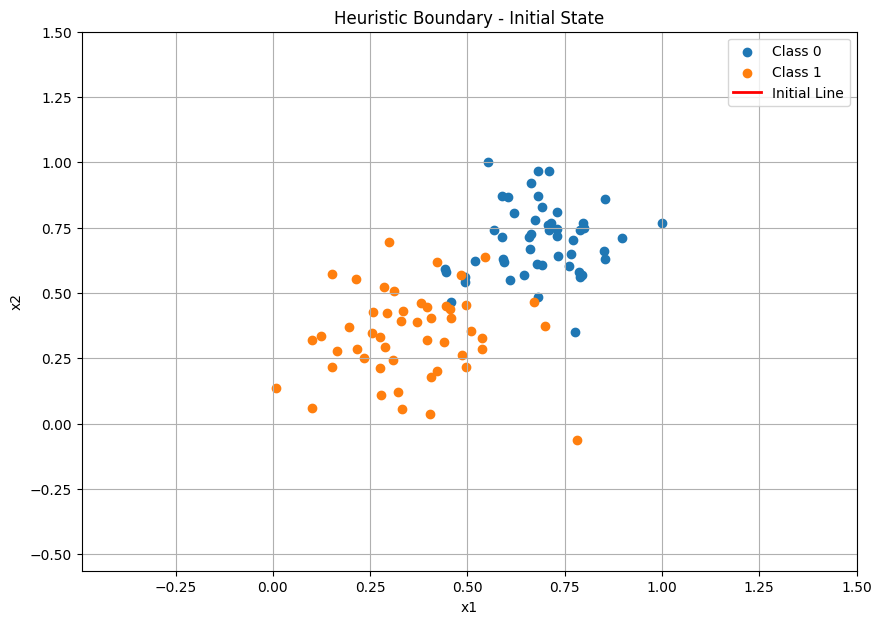

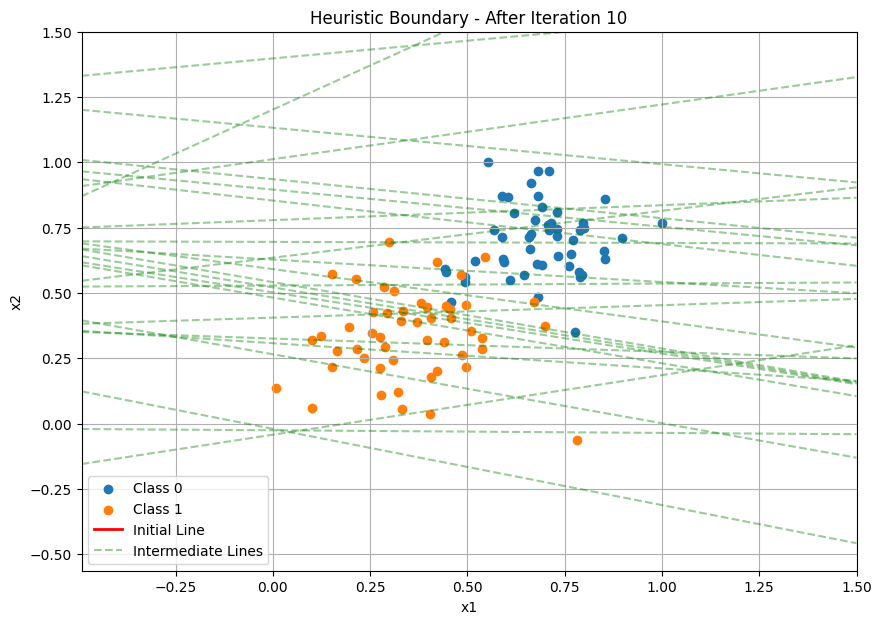

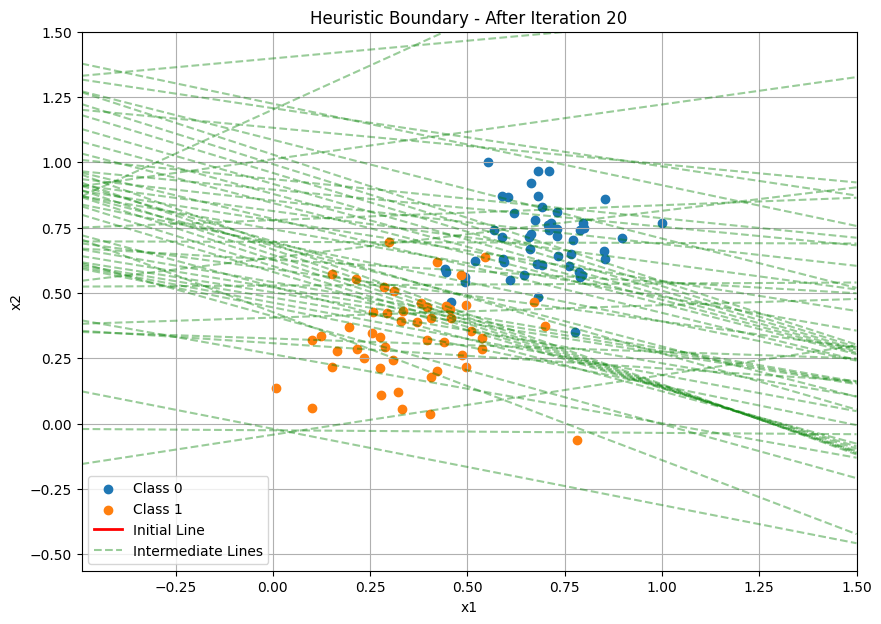

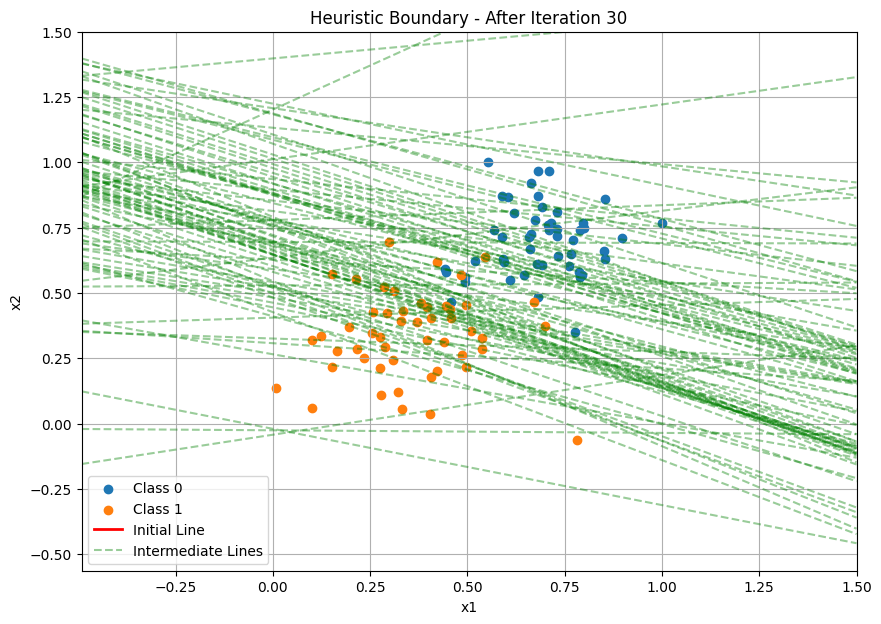

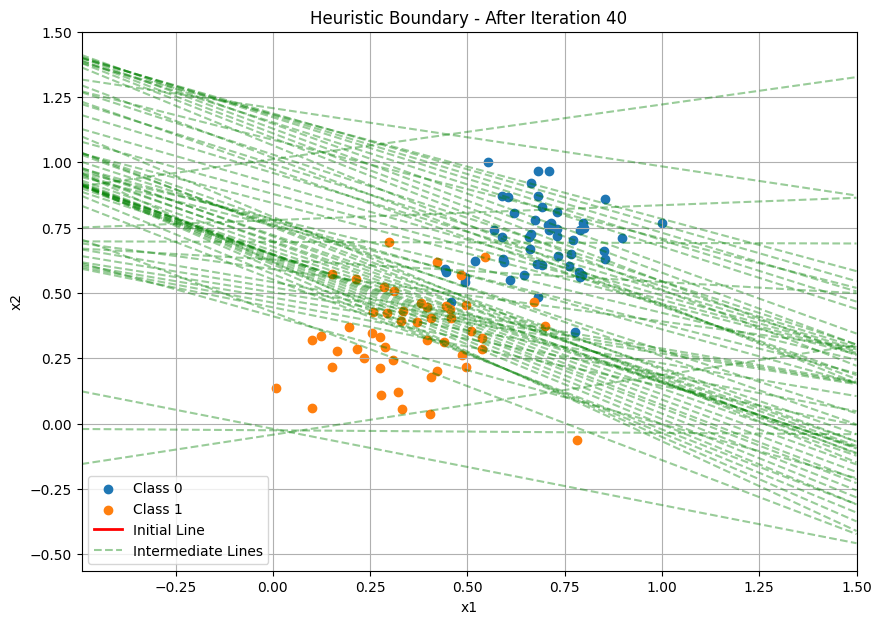

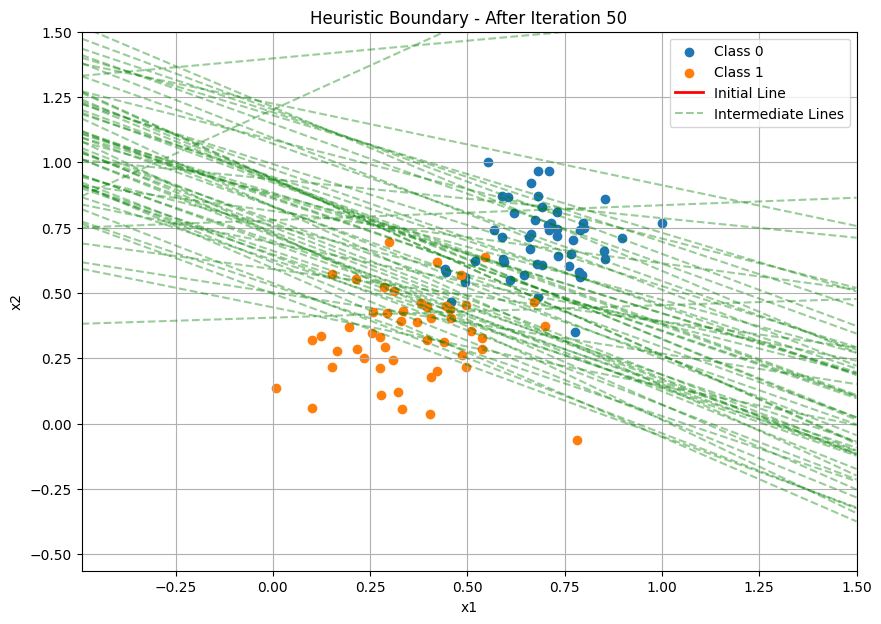

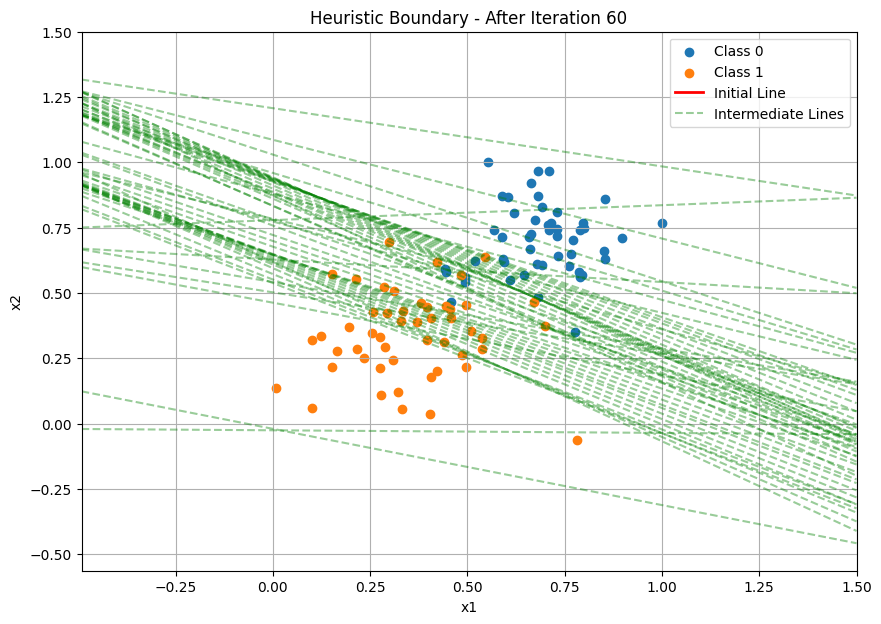

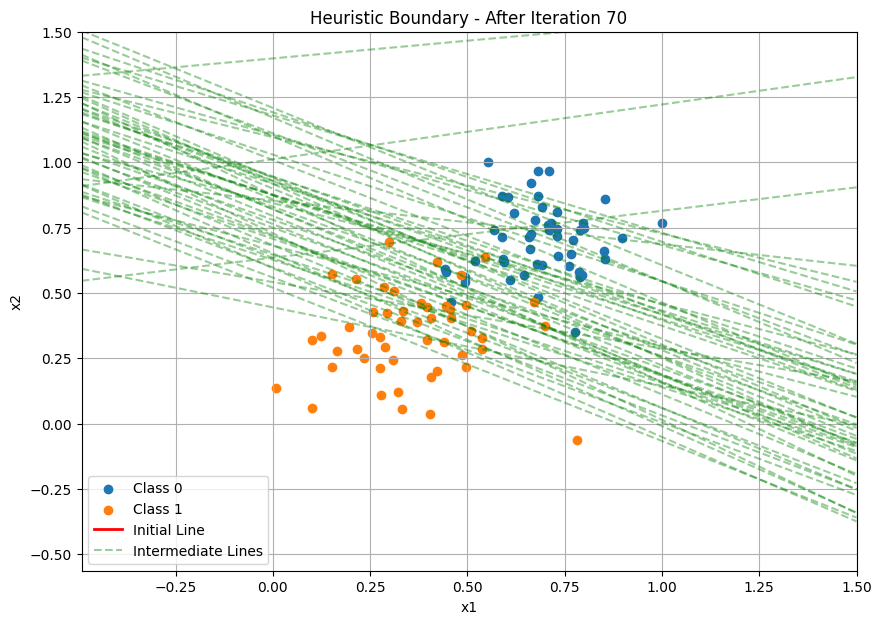

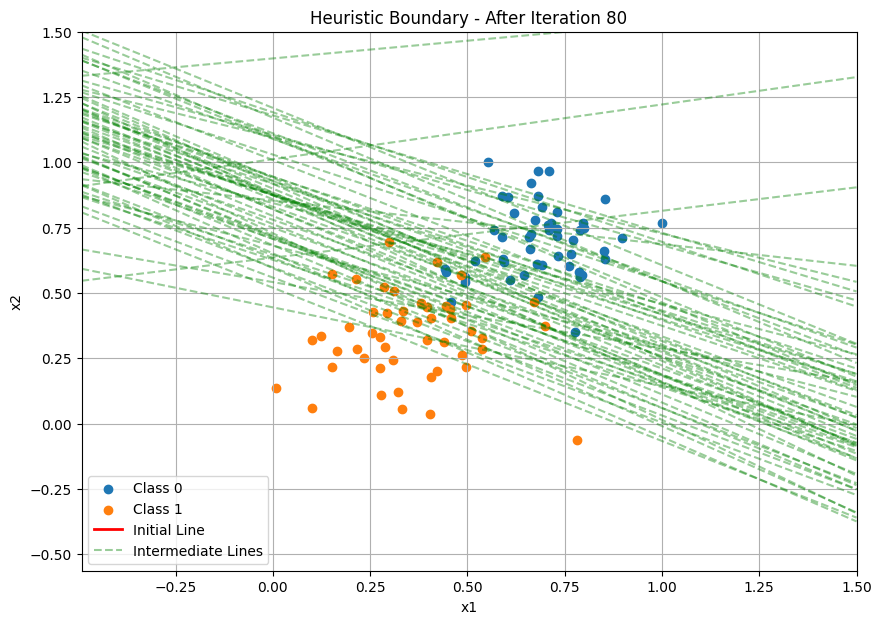

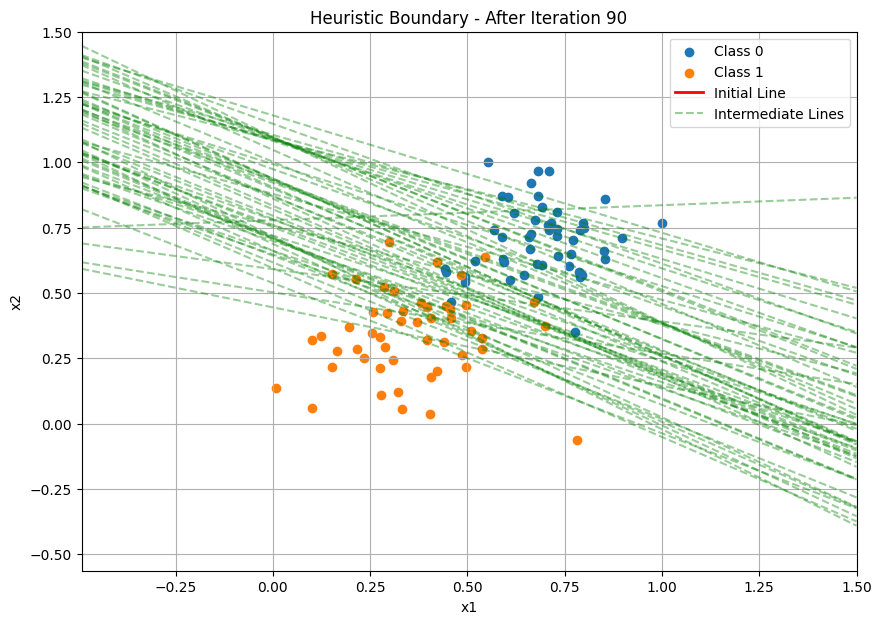

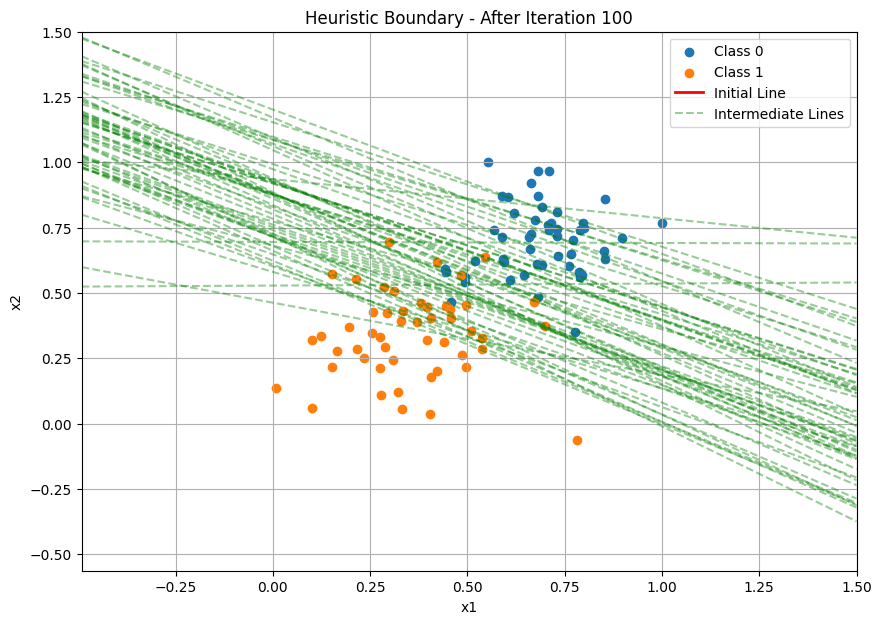

Heuristic: Reached max iterations (100).


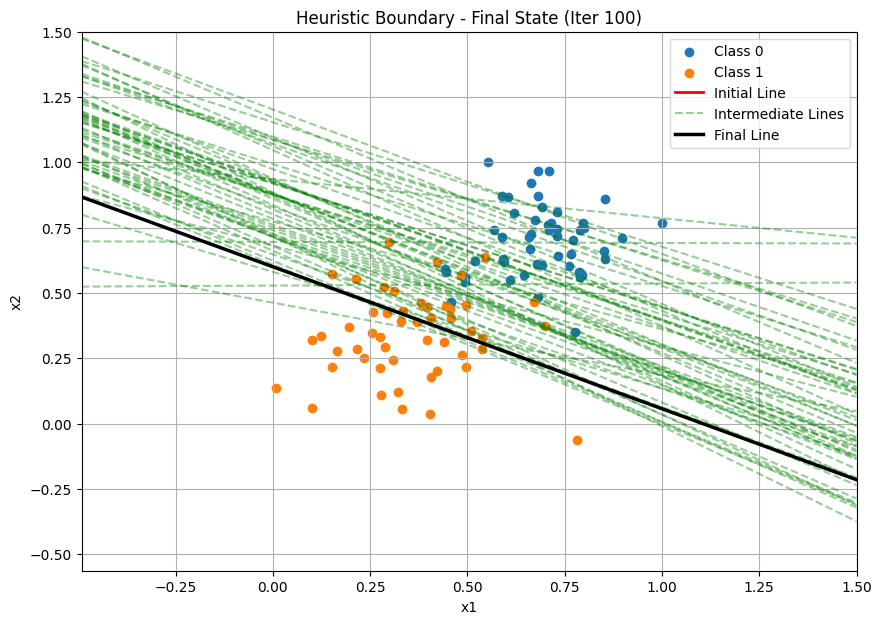

Heuristic training finished.


In [5]:
# Run Heuristic Perceptron (Modified)

# --- Parameters ---
HEURISTIC_LR = 0.1
HEURISTIC_ITER = 10
HEURISTIC_PLOT_INTERVAL = 10 # Plot every 10 iterations

# Pass the original X, y to the training function
heuristic_lines_history = perceptron_heuristic(
    X, y,
    learning_rate=HEURISTIC_LR,
    max_iter=HEURISTIC_ITER,
    plot_interval=HEURISTIC_PLOT_INTERVAL
)

print("Heuristic training finished.")


In [6]:
# Gradient Descent Functions Definition (Modified)

def sigmoid(z):
    """Sigmoid activation function."""
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

def compute_log_loss(y_true, y_pred_proba):
    """Computes binary cross-entropy (log loss)."""
    epsilon = 1e-10
    y_pred_proba = np.clip(y_pred_proba, epsilon, 1 - epsilon)
    loss = -np.mean(y_true * np.log(y_pred_proba) + (1 - y_true) * np.log(1 - y_pred_proba))
    return loss

# Modified to accept X_orig, y_orig for plotting inside
def perceptron_gradient_descent(X_orig, y_orig, learning_rate=0.1, epochs=100, plot_interval=10):
    """
    Implements the Perceptron using Gradient Descent with Sigmoid activation.
    Plots decision boundary every plot_interval epochs.
    """
    
    # Add bias term
    X_bias = np.hstack((np.ones((X_orig.shape[0], 1)), X_orig))
    n_samples, n_features_with_bias = X_bias.shape
    y_true = y_orig.reshape(-1) # Ensure y is 1D array

    # Initialize weights
    w = np.random.randn(n_features_with_bias) * 0.01
    # Store only weights needed for plotting intervals + initial/final
    lines_history_for_plotting = [w.copy()]
    loss_history = [] # Store (epoch, loss) tuples

    print(f"Starting Gradient Descent (LR={learning_rate}, Epochs={epochs})")
    # Plot initial boundary
    plot_decision_lines(X_orig, y_orig, lines_history_for_plotting,
                        title=f"GD Boundary - Initial State",
                        is_intermediate_plot=True)

    for epoch in range(epochs):
        
        # Calculate predictions
        z = np.dot(X_bias, w)
        predictions = sigmoid(z)

        # Calculate gradient
        error = predictions - y_true
        gradient = np.dot(X_bias.T, error) / n_samples

        # Update weights
        w -= learning_rate * gradient

        # Record loss and potentially plot every plot_interval epochs
        # Use epoch+1 for 1-based counting in interval check
        if (epoch + 1) % plot_interval == 0 and epoch > 0:
            loss = compute_log_loss(y_true, predictions)
            loss_history.append((epoch, loss)) # Store loss at this interval
            # Add current weights to history for plotting this snapshot
            lines_history_for_plotting.append(w.copy())
            plot_decision_lines(X_orig, y_orig, lines_history_for_plotting,
                                title=f"GD Boundary - After Epoch {epoch + 1}",
                                is_intermediate_plot=True)
           
    # Store final weights and loss
    final_predictions = sigmoid(np.dot(X_bias, w))
    final_loss = compute_log_loss(y_true, final_predictions)
    
    # Ensure final loss is recorded if last epoch wasn't a multiple of interval
    if not loss_history or loss_history[-1][0] != epochs - 1:
         loss_history.append((epochs - 1, final_loss))
    else: # Update last recorded loss if it was the final epoch
         loss_history[-1] = (epochs - 1, final_loss)

    # Add final weights for the final plot call
    lines_history_for_plotting.append(w.copy())

    print(f"Gradient Descent: Finished {epochs} epochs. Final Loss: {final_loss:.4f}")

    # Plot the final boundary state clearly
    plot_decision_lines(X_orig, y_orig, lines_history_for_plotting,
                        title=f"GD Boundary - Final State (Epoch {epochs})",
                        is_intermediate_plot=False) # Final plot

    return lines_history_for_plotting, loss_history # Return history if needed


In [7]:
# Loss Curve Plotting Function Definition

def plot_loss_curve(loss_history):
    """Plots the log loss over epochs."""
    if not loss_history:
        print("No loss history to plot.")
        return

    plt.figure(figsize=(8, 6))
    epochs, losses = zip(*loss_history) # Unzip the list of tuples

    plt.plot(epochs, losses, marker='o', linestyle='-')
    
    # Adjust x-axis label to reflect actual epochs recorded
    plt.xlabel('Epoch (recorded every 10 epochs)')
    plt.ylabel('Log Loss')
    plt.title('Loss Curve')
    plt.grid(True)
    plt.show()


Starting Gradient Descent (LR=0.1, Epochs=100)


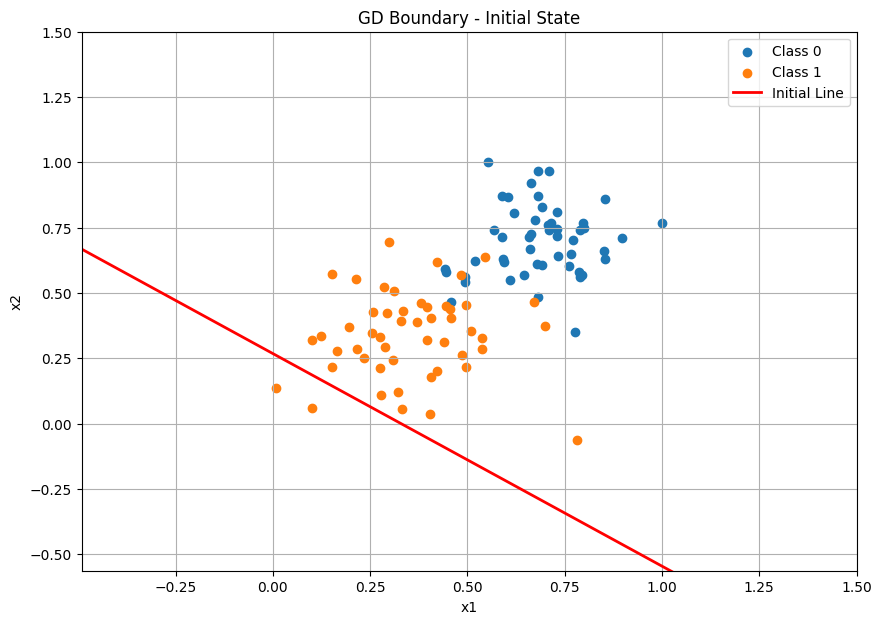

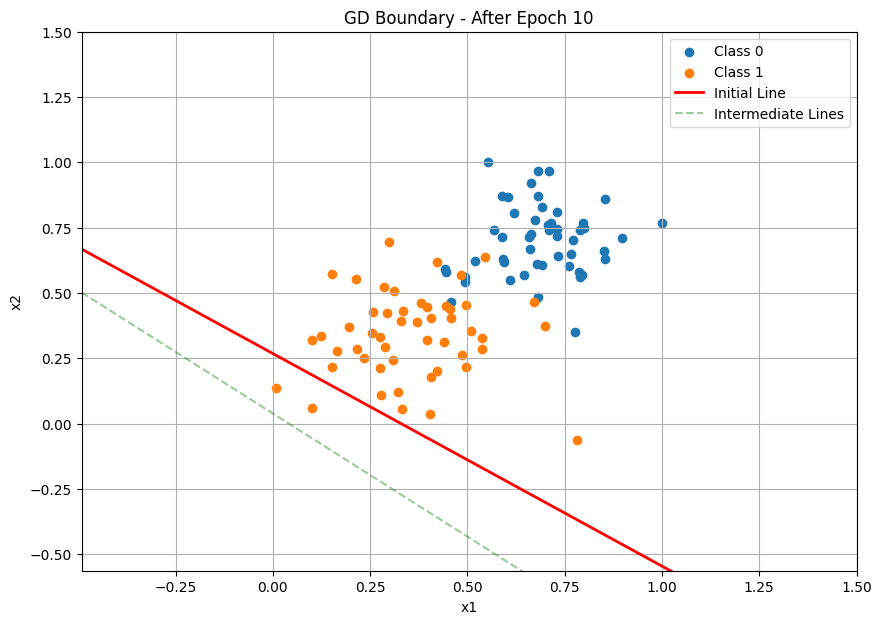

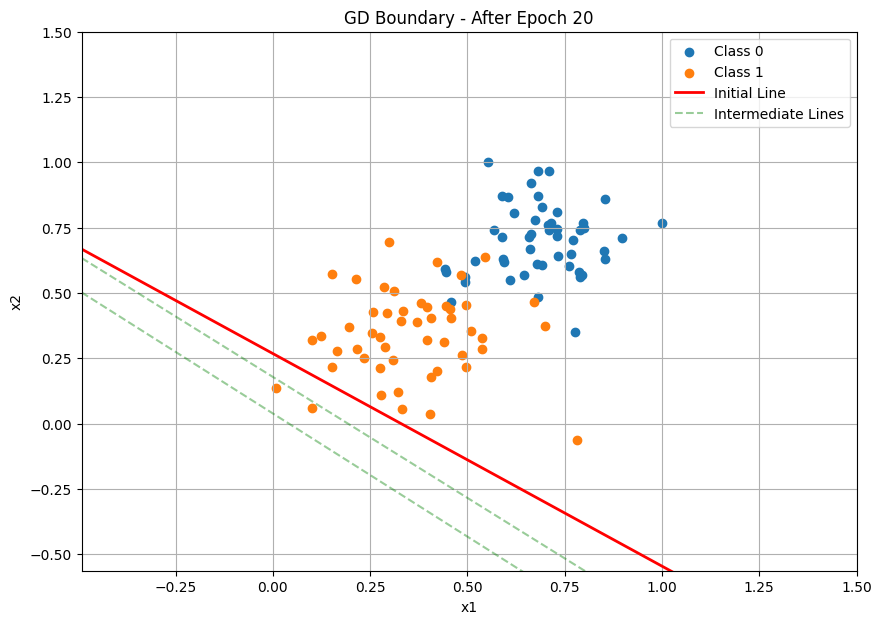

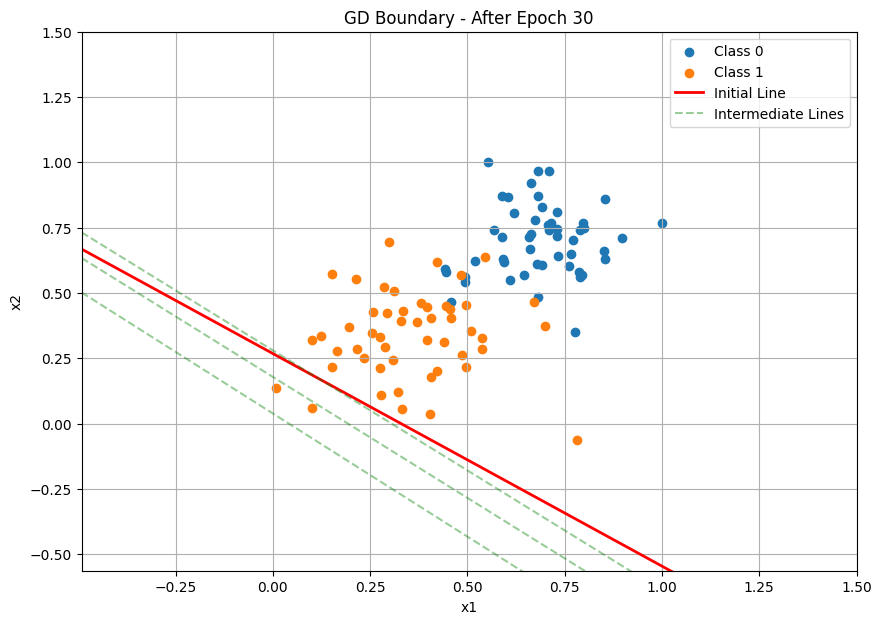

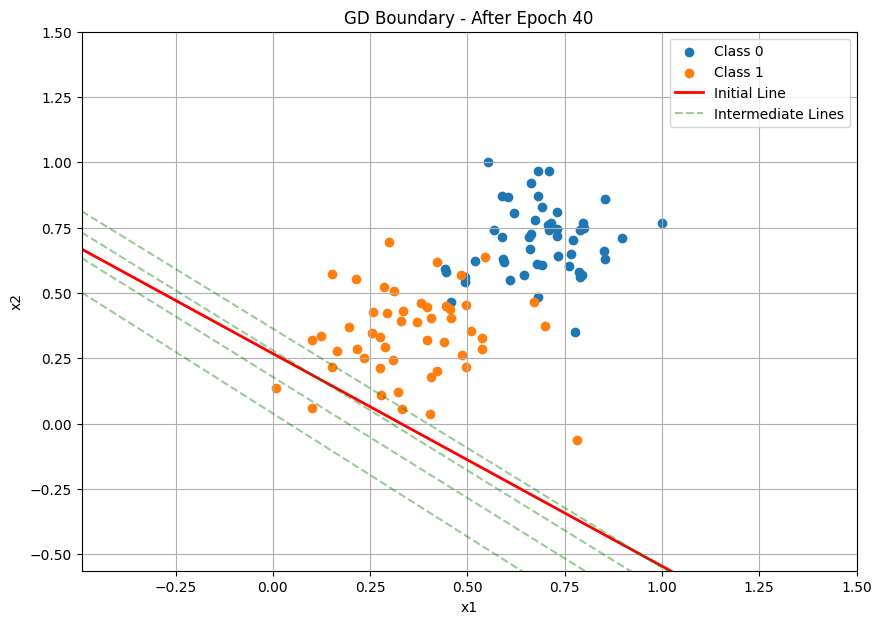

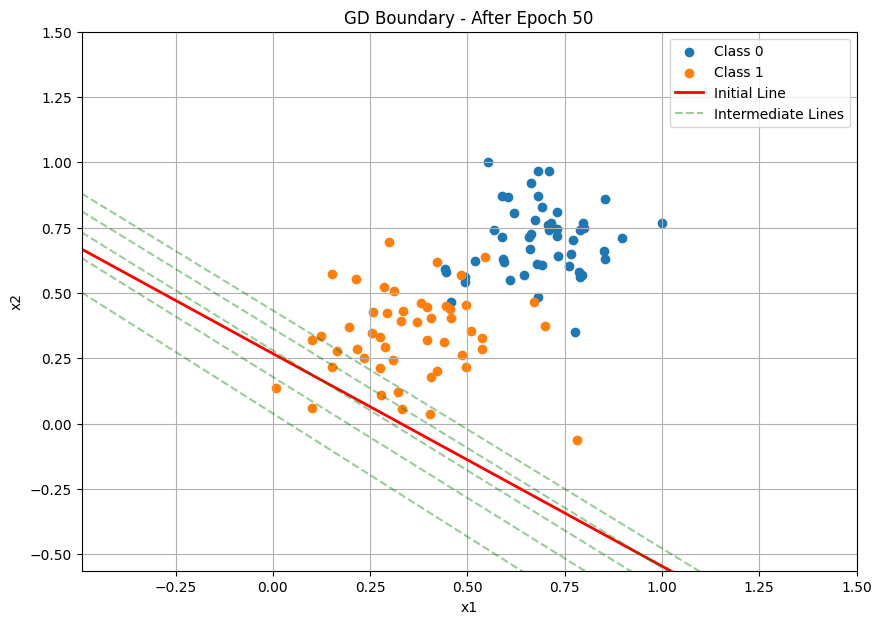

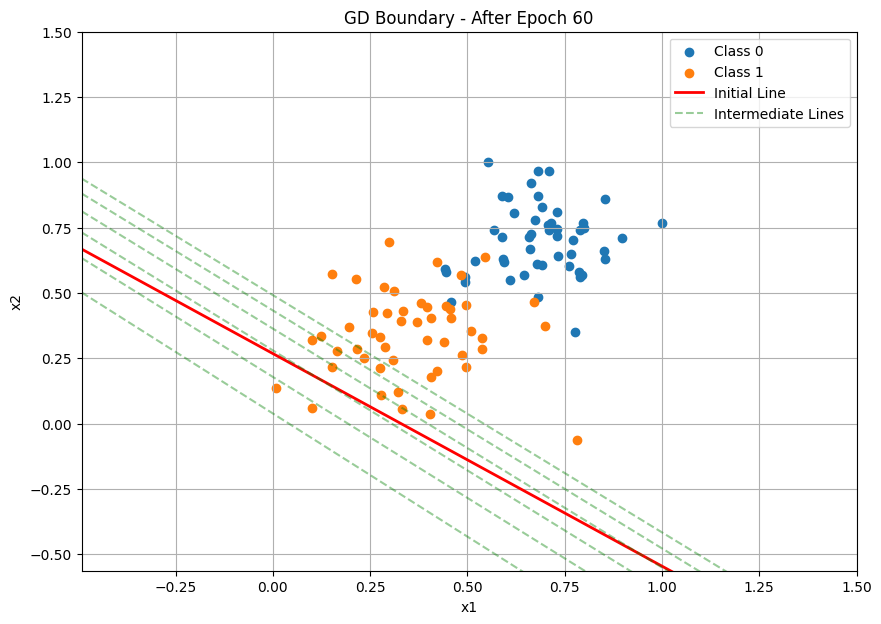

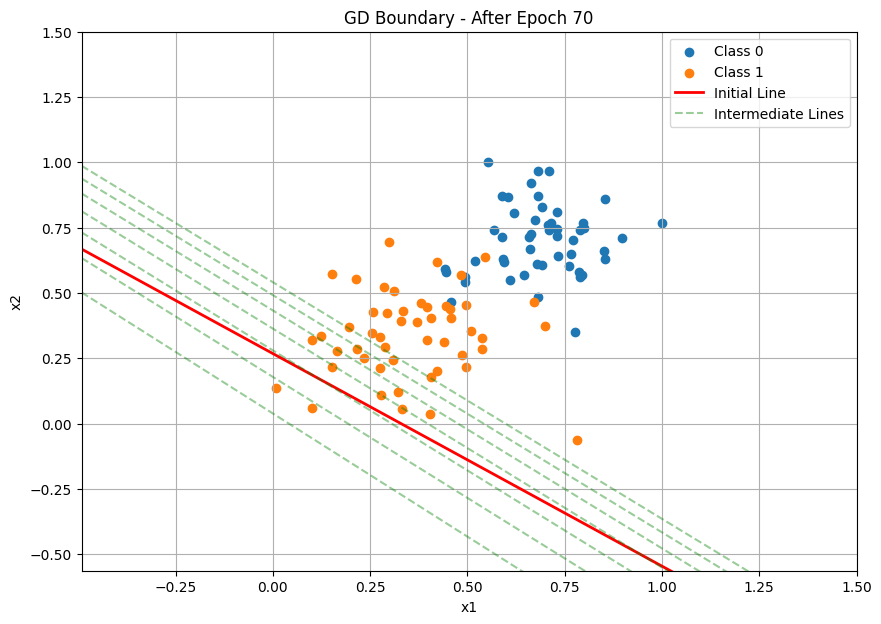

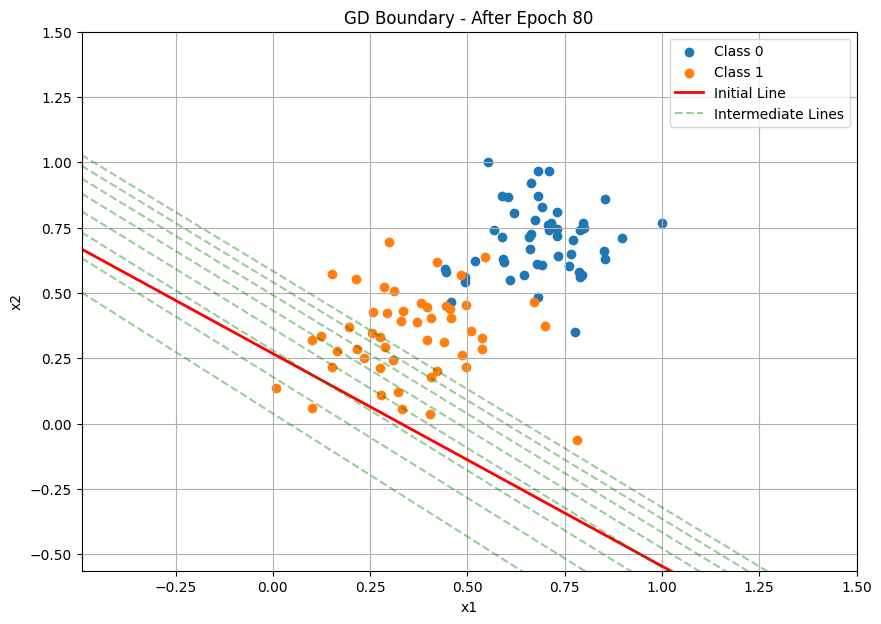

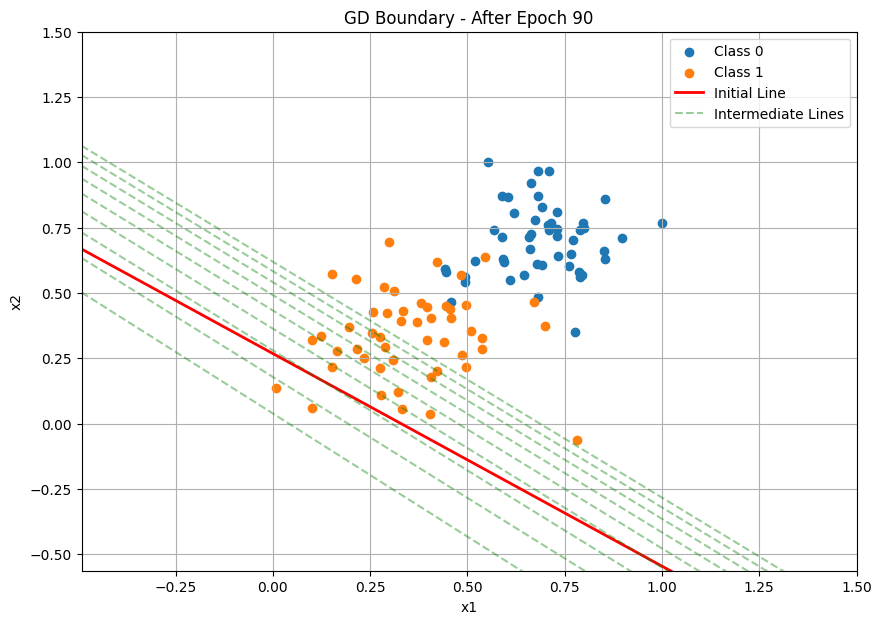

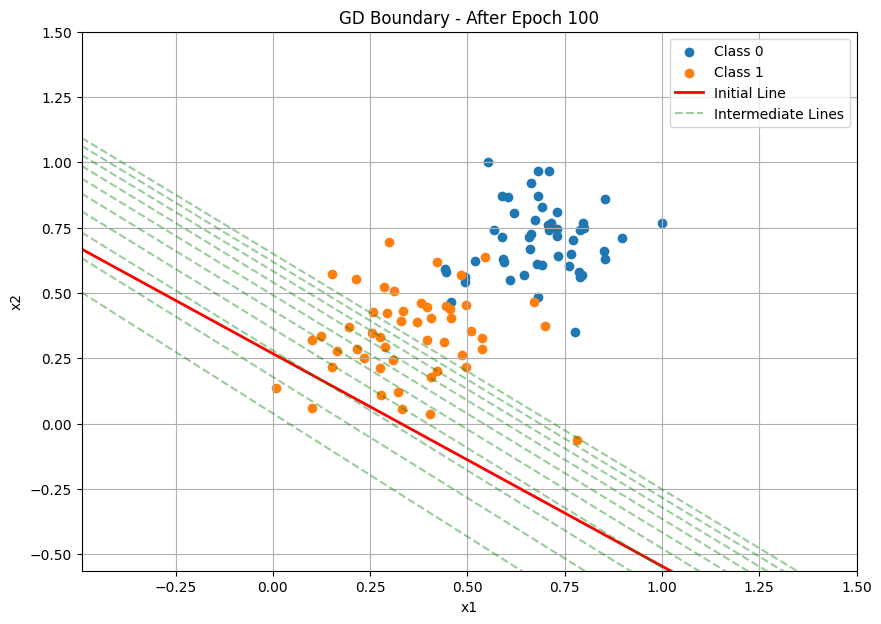

Gradient Descent: Finished 100 epochs. Final Loss: 0.6054


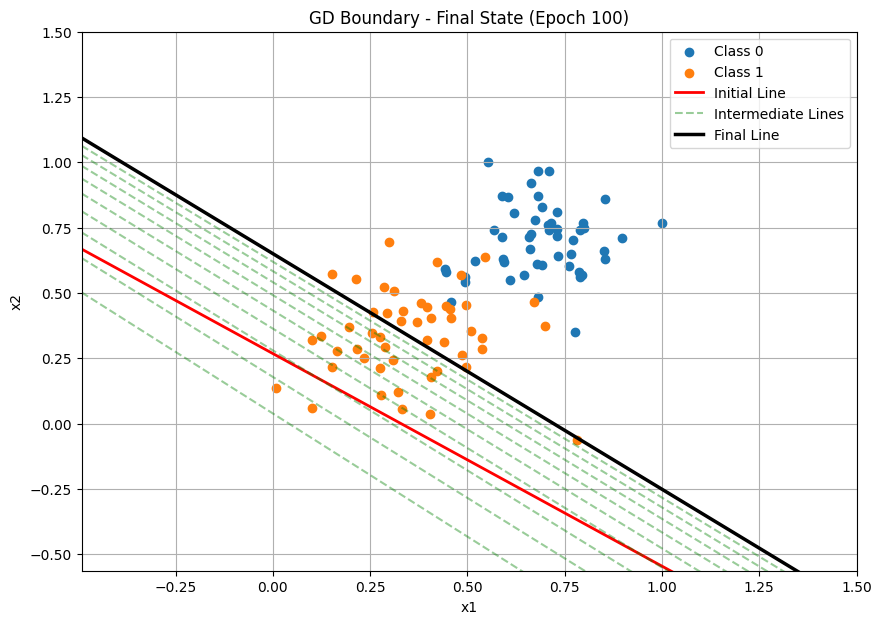

Gradient Descent training finished.


In [8]:
# Run Gradient Descent (Modified)

# --- Parameters ---
GD_LR = 0.1
GD_EPOCHS = 100
GD_PLOT_INTERVAL = 10 # Plot every 10 epochs

gd_lines_history, gd_loss_list = perceptron_gradient_descent(
    X, y,
    learning_rate=GD_LR,
    epochs=GD_EPOCHS,
    plot_interval=GD_PLOT_INTERVAL
)

print("Gradient Descent training finished.")



Plotting Loss Curve...


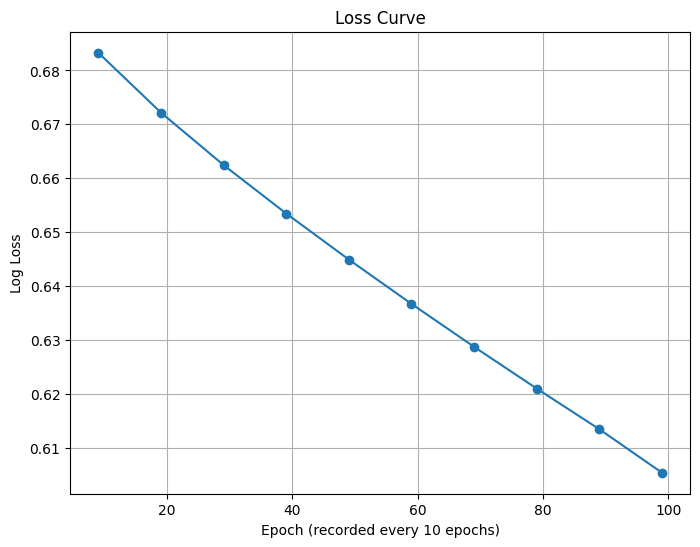

In [9]:
# Plot Gradient Descent Loss Curve 
print("\nPlotting Loss Curve...")
plot_loss_curve(gd_loss_list)
